In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import plotly.express as px
import plotly.graph_objects as go

import utils.eval_n_plot as eval_n_plot

%load_ext autoreload
%autoreload 2

In [15]:
plt_save_dir = "../plots"

### MVO Analysis

In [3]:
# Load MVO Results
results_dir = "../results/20250702_1539_mvo_backtest_[2012-01-01,2021-12-31]_freq=1d"

mvo_history_df = pd.read_parquet(f"{results_dir}/mvo_history.parquet")
mvo_metrics_df = pd.read_csv(f"{results_dir}/mvo_metrics.csv")

naive_portfolio_df = pd.read_parquet(f"{results_dir}/naive_history.parquet")
naive_metrics_df = pd.read_csv(f"{results_dir}/naive_metrics.csv")

In [4]:
START_DATE = "2012-01-01"
END_DATE = "2021-12-31"

df_spy = pd.read_parquet("../data/snp/prices_sp500_1d.parquet")
ref_ticker = "^GSPC"

initial_balance = 100_000
shares_spy = initial_balance / df_spy[ref_ticker].loc[df_spy.index > START_DATE].iat[0]

In [13]:
# eval_n_plot.plot_portfolio_val_interactive(
#     START_DATE,
#     END_DATE,
#     mvo_history_df,
#     # naive_portfolio_df=naive_portfolio_df,
#     ref_df=df_spy,
#     ref_ticker=ref_ticker,
#     initial_shares=shares_spy,
# )

[ 10  30  60  90 120 150 252 504 756]


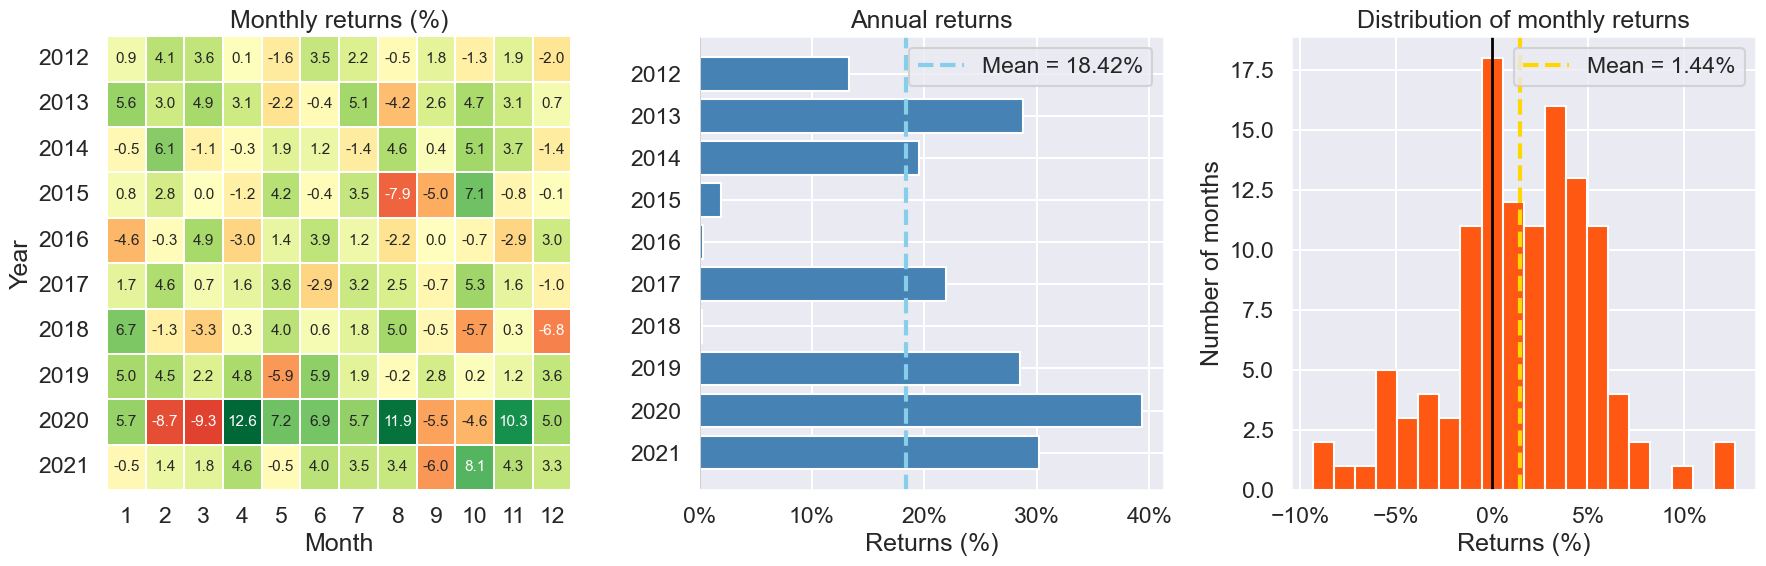

In [18]:
# Filter relevant lookback
lookback = 756
print(mvo_history_df["lookback"].unique())
focus_df = mvo_history_df[mvo_history_df["lookback"] == lookback]

monthly_pivot, annual_df = eval_n_plot.calc_monthly_annual_rets(focus_df, initial_balance)
fname = f"paper_fig4_mvo_returns_{lookback}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

### DRL Analysis

In [6]:
DATA_DIR = "../data/snp"
RETURNS_PATH = os.path.join(DATA_DIR, "returns_1d.parquet")
PRICES_PATH = os.path.join(DATA_DIR, "prices_1d.parquet")
VOLA_PATH = os.path.join(DATA_DIR, "vola_1d.parquet")
SP500_PATH = os.path.join(DATA_DIR, "prices_sp500_1d.parquet")

df_ret = pd.read_parquet(RETURNS_PATH)
df_prices = pd.read_parquet(PRICES_PATH)
df_vol = pd.read_parquet(VOLA_PATH)
df_sp500 = pd.read_parquet(SP500_PATH)

# Ensure datetime index
df_ret.index = pd.to_datetime(df_ret.index)
df_prices.index = pd.to_datetime(df_prices.index)
df_vol.index = pd.to_datetime(df_vol.index)
df_sp500.index = pd.to_datetime(df_sp500.index)

# Evaluation period
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2021-12-31")

# Slice data according to the evaluation period
df_prices = df_prices.loc[start_date:end_date].copy()
df_ret = df_ret.loc[start_date:end_date].copy()
df_vol = df_vol.loc[start_date:end_date].copy()
df_sp500 = df_sp500.loc[start_date:end_date].copy()

print("Data loaded successfully:")
print(f"Returns: {df_ret.shape}, {df_ret.index.min()} to {df_ret.index.max()}")
print(f"Prices: {df_prices.shape}, {df_prices.index.min()} to {df_prices.index.max()}")
print(f"Volatility: {df_vol.shape}, {df_vol.index.min()} to {df_vol.index.max()}")
print(f"SP500: {df_sp500.shape}, {df_sp500.index.min()} to {df_sp500.index.max()}")

Data loaded successfully:
Returns: (4028, 11), 2006-01-03 00:00:00 to 2021-12-31 00:00:00
Prices: (4028, 11), 2006-01-03 00:00:00 to 2021-12-31 00:00:00
Volatility: (4028, 3), 2006-01-03 00:00:00 to 2021-12-31 00:00:00
SP500: (4028, 1), 2006-01-03 00:00:00 to 2021-12-31 00:00:00


['../models/random_run/agent_3-1_seed=10_test=2014_valrew=2.72.zip',
 '../models/random_run/agent_5-2_seed=21_test=2016_valrew=7.06.zip',
 '../models/random_run/agent_1-5_seed=4_test=2012_valrew=-13.27.zip',
 '../models/random_run/agent_1-3_seed=2_test=2012_valrew=-10.94.zip',
 '../models/random_run/agent_5-3_seed=22_test=2016_valrew=8.71.zip']
['portfolio_10_test=2021.csv', 'portfolio_1_test=2012.csv', 'portfolio_2_test=2013.csv', 'portfolio_3_test=2014.csv', 'portfolio_4_test=2015.csv', 'portfolio_5_test=2016.csv', 'portfolio_6_test=2017.csv', 'portfolio_7_test=2018.csv', 'portfolio_8_test=2019.csv', 'portfolio_9_test=2020.csv']


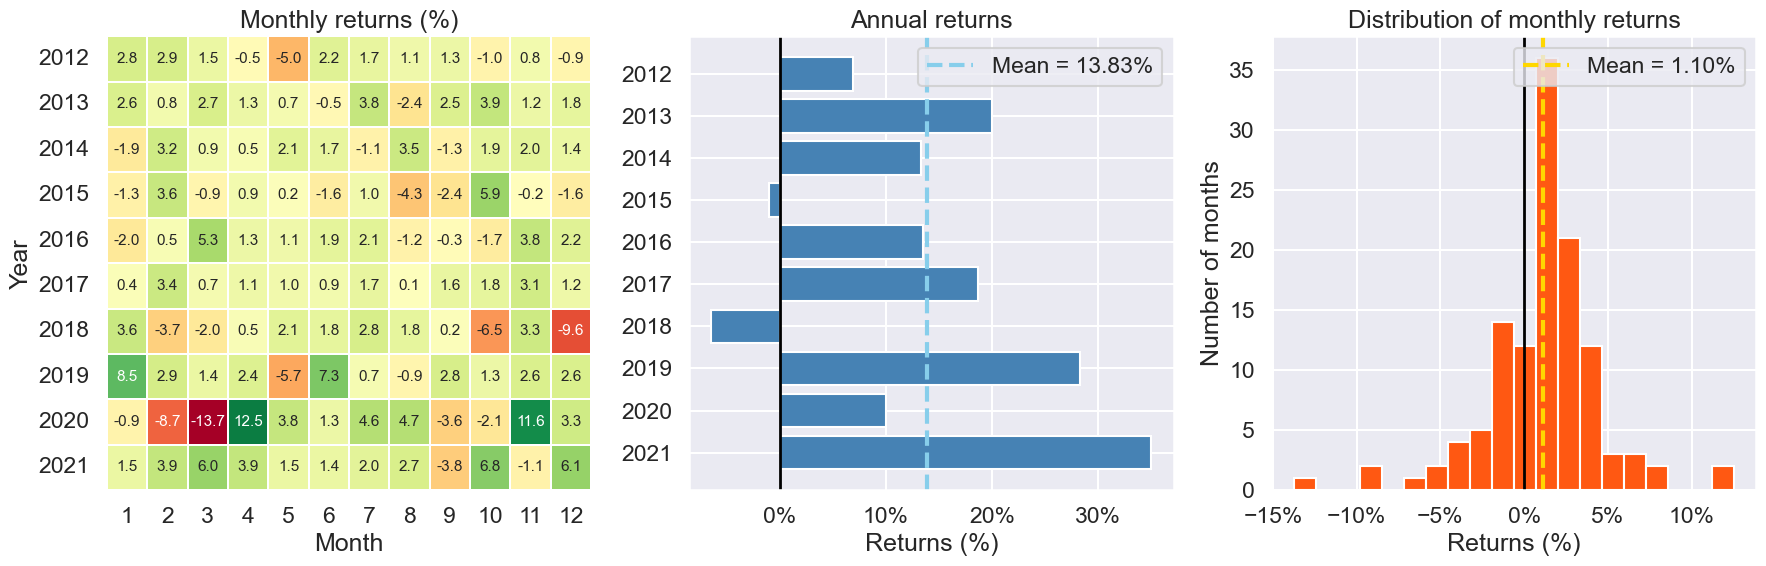

In [ ]:
# DRL model timestamp
MODEL_FNAME = "random_run" # random_run, paper_setting
model_dir = f"../models/{MODEL_FNAME}"

# get (first) config file in directory
files = os.listdir(model_dir)
config_files = [f for f in files if f.endswith(".json")]
config_path = os.path.join(model_dir, config_files[0])

agent_files = [f for f in files if f.startswith("agent_")]
agent_paths = [os.path.join(model_dir, f) for f in agent_files]
pprint(agent_paths[:5])

# get csv files in dir
# fname contains portfolio
csv_files = sorted(
    [f for f in os.listdir(model_dir) if f.endswith(".csv") and "portfolio" in f]
)
print(csv_files)

# load csv files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(model_dir, file))
    df.reset_index(inplace=True)
    # rename index to trading_day
    df.rename(columns={"index": "trading_day"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    dfs.append(df)

df_drl_port = pd.concat(dfs, ignore_index=True).sort_values(by=["date"]).reset_index(drop=True)

monthly_pivot, annual_df = eval_n_plot.process_drl_portfolios(df_drl_port)
fname = f"paper_fig3_drl_{MODEL_FNAME}"

eval_n_plot.plot_fig4(monthly_pivot, annual_df, plt_save_dir, fname)

In [97]:
df_drl_port_res = df_drl_port.groupby("year", as_index=False)["portfolio_value"].last()

years = df_drl_port_res["year"].unique()
start_dates = pd.to_datetime([f"{yr}-01-01" for yr in years])
end_dates = pd.to_datetime([f"{yr}-12-31" for yr in years])

spy_start_prices = [
    df_spy.loc[df_spy.index > start, "^GSPC"].iloc[0] for start in start_dates
]
spy_end_prices = [df_spy.loc[df_spy.index < end, "^GSPC"].iloc[-1] for end in end_dates]

shares_start = 100_000 / pd.Series(spy_start_prices)
snp_values = shares_start * pd.Series(spy_end_prices)
df_drl_port_res["snp_value"] = snp_values.values

df_drl_port_res

# TODO : add MVO portfolio values in other cols
# then identify best and worst performing model / agent

,year,portfolio_value,snp_value
0,2012,106470.429260,109817.079023
1,2013,120460.418710,125892.007150
2,2014,110654.054569,113557.468959
3,2015,100280.055988,100250.712097
4,2016,115413.401261,111237.369457
5,2017,114590.007690,118415.027478
6,2018,96321.613003,92207.534515
7,2019,126039.678610,128336.713165
8,2020,116297.558903,114555.302644
9,2021,132852.418900,129132.182362


In [98]:
# plot portfolio value development with hue = year
# plt.figure(figsize=(15, 5))
# sns.lineplot(x="trading_day", y="portfolio_value", hue="year", data=df_drl_port)
# plt.axhline(y=100_000, color="grey", linestyle="--")
# plt.show()

from plotly.colors import diverging, sequential
# color_sequence = diverging.RdBu
color_sequence = sequential.Viridis

fig = px.line(
    df_drl_port,
    x="trading_day",
    y="portfolio_value",
    color="year",
    color_discrete_sequence=color_sequence,
    title="Portfolio Value Development by Year"
)

# Add horizontal line at y=100_000
fig.add_hline(
    y=100_000,
    line_dash="dash",
    line_color="gray",
    annotation_text="Initial Value",
    annotation_position="top left"
)

fig.update_layout(
    height=600,
    width=1200,
    xaxis_title="Trading Day",
    yaxis_title="Portfolio Value",
    legend_title="Year"
)

fig.show()